<a href="https://colab.research.google.com/github/shawk17/563-shawk17/blob/main/Project_1_offlattice_mc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 1 Code

$$V_{LJ} = 4ϵ[(\frac{σ}{r})^{12} - (\frac{σ}{r})^6]$$

In [1]:
#HW4
import numpy as np
import matplotlib.pyplot as plt
import time
from itertools import combinations, product
import copy
import math

NA = 6.022E23 # Avogadro's number
R = 8.314472 # J/K/mol

class Particle():
  def __init__(self,L, dim=3, id = 1):
    loc = np.random.rand(dim)*L
    self.location = np.array(loc)
    self.id = id

  def __repr__(self):
    return f'{self.id}'

In [15]:
class Volume():
  def __init__(self,N=5,L=4,T=1.0, epsilon=1, sigma = 1, m = 40,dim=3, rcut=2.5):
    self.rcut = rcut*sigma
    self.L = L
    self.N = N
    self.epsilon = epsilon
    self.T = T
    self.sigma = sigma
    self.m = m
    self.dim = dim

    self.particles = []
    for i in range(self.N):
      p = Particle(L, dim=dim, id = i)
      self.particles.append(p)


    self.particle_pairs = list(combinations(self.particles, 2))
    self.E = self.energy()
    self.m = m
    self.V = self.L**3

  def energy(self):
    energy = 0
    for pair in self.particle_pairs:
      energy += self.LJ(pair[0].location, pair[1].location)
    return energy

  def particle_energy(self, p):
    energy = 0
    for particle in self.particles:
      if not p == particle:
        energy += self.LJ(particle.location, p.location)
    return energy

  def position_energy(self, pos, p=None):
    energy = 0
    for particle in self.particles:
      if not p == particle:
        energy += self.LJ(particle.location, pos)
    return energy

  def LJ(self, site1, site2):
    delta = site1 - site2
    delta -= self.L * np.round(delta / self.L)  # Minimum image convention
    r = np.linalg.norm(delta)
    if r > self.rcut:
      return 0

    r /= self.sigma

    if r == 0:  # Avoid division by zero
        return 0
    # Compute potential energy
    U = 4 * self.epsilon * (1/r**12 - 1/r**6)

    return U

In [16]:
# Simulation class
class Simulation():
  def __init__(self,move=0.1,N=5,L=3,T=1.,seed=2, verbose = True, **kwargs):
    np.random.seed(seed)
    self.volume = Volume(N,L,T, **kwargs)
    self.volume.E = self.volume.E
    self.move = move
    self.accepted = 0
    self.rejected = 0
    self.steps = 0
    self.pressures = []
    self.energies = []
    self.verbose = verbose

  def __repr__(self):
    return f'Vol: {self.volume.V:.3g}, accept: {self.accepted}, reject {self.rejected}, steps: {self.steps}'

  def trial_move(self):
    p = np.random.choice(self.volume.particles)
    dr = np.random.uniform(-self.move, self.move, len(p.location))
    new_pos = (p.location + dr) % self.volume.L # Apply periodic boundaries

    poldE = self.volume.particle_energy(p)
    pnewE = self.volume.position_energy(new_pos, p=p)
    dE = pnewE - poldE

    self.steps += 1
    if dE < 0 or np.random.rand() < np.exp(-dE/self.volume.T):
      p.location = new_pos
      self.volume.E += dE
      self.accepted += 1
      return
    else:
      self.rejected += 1
      return

  def run(self, steps, move_gradient = None, max_time = 300, keep_loc = False):
    gradient=False
    self.particle_locs = []

    if not move_gradient is None:
      gradient = True
      move_gradient = np.linspace(move_gradient[0], move_gradient[1], steps)

    t1 = time.perf_counter()
    if self.verbose:
      print(f'The number of particles is {self.volume.N}')
      print(f'Starting per particle energy {self.volume.E/self.volume.N:.4g}')

    for i in range(steps):
      self.trial_move()
      self.energies.append(self.volume.E/self.volume.N)
      if gradient:
        self.move = move_gradient[i]
      if time.perf_counter() - t1 > max_time:
        print(f'Reached max time of {max_time} seconds')
        break
      if keep_loc:
        self.particle_locs.append(copy.deepcopy(self.volume.particles))
    t2 = time.perf_counter()
    if self.verbose:
      print(f'Ran {steps} in {t2-t1:.5g} seconds')
      print(f'Acceptance: {self.accepted/steps};    Rejection: {self.rejected/steps}')
      print(f'Ending per particle energy {self.volume.E/self.volume.N:.4g}')
    return t2 - t1

In [17]:
# N/V = 0.5
kb = 1.380649E-23 # J/K
simulations = []
durations = []
Cvs = []

step = 5000
T = 1
N = 50
rho = 0.5
L = (N / rho)**1/3
pressure_steps = 1000

sim = Simulation(move=0.1, N=N, L=L, T=T, epsilon=1,
                  sigma=1, m=1, dim=3, verbose=True, seed = 2)
sim.run(step, move_gradient = None)


The number of particles is 50
Starting per particle energy 32.25
Ran 5000 in 5.6568 seconds
Acceptance: 0.9956;    Rejection: 0.0044
Ending per particle energy -0.01397


5.656793655999991

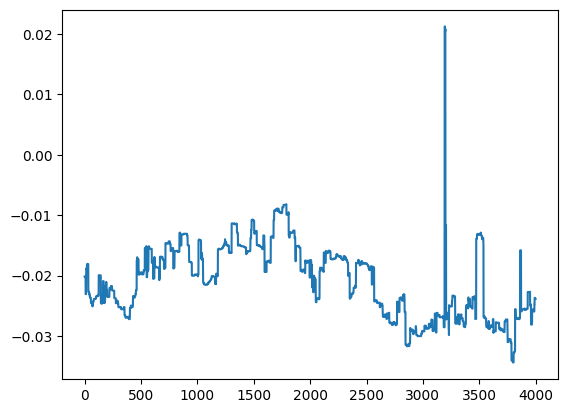

In [12]:
plot_amount = 1000
plt.plot(sim.energies[plot_amount:])
plt.show()

1. Pick a physical system you’re curious about (e.g., Argon, Methane, Lennard-Jonesium, ethane, etc).
  * I am doing argon as a LJ systme, ϵ/kb=120 K, σ=0.34nm, and m=40d
1. Determine a representation of it that balances ease of implementation with probing its thermodynamics.
  * Reduced units, LJ potential, PBC, I am not doing any tail corrections, I am considering every particle interaction, (no truncation).
  * I added Verlet boxes, this works well for larger system sizes, but for the 50 particles I was considering it didn't help at all, it actually hurt. I put in a check to make sure the cutoff was large enough, so it didn't start double counting particles.
1. Characterize your model’s performance:
  1. How long does it take to equilibrate at extremes of state (high densities, low temperatures)?
    * With high densities, low temp it takes (around the supposed freezing point, and density) 50 particles about 5000 steps to equilibrate, however, I didn't not see a pressure drop arround that point.
  2. How small is too small? How big is too big?
    * For Google Colab, I predict can do about 1000 particles for 5000 steps in 5 minutes, as it seems to be scaling roughly linearly. It with particles, it seems like it should scale faster than this though.
1. Contrast your system with an ideal gas:
  1. How does the structure of your model vary with state, and how does it compare to particles with no interactions?
    * My model seems to almost perfectly follow the ideal gas law, at least at changing only volume, only temperature, or only number.
  1. Does the heat capacity of your system depend on state differently than an ideal gas?
    * Currently yes, but it shouldn't, I can't figure out why. At least it shouldn't arround the freezing and melting points.
    * Running the systems for longer seems to get it closer to an ideal gas, I am wondering if I wasn't letting it equilibrate.
  1. Can you derive or numerically determine an equation of state?
    * Yes, I could, see below, it is nearly indistinguishable from an ideal gas.
1. Summarize where your model works well to give insight, where it breaks down, and any revelations that occurred while working towards 1-4.
  * My model works well when simulating an ideal gas, it doesn't predict freezing or melting points, at least not at the system sizes I tried.
  * I am still uncertain why my heat capcity is so off, I tried for hours to figure that out. I think my equations right, but I'll need some help.
  * It equilibrates to pressure surprisingly quickly, way faster than it equilibrates to energy. Why is that?
  * If I had more time I would look more closely at the melting and freezing points to see if I could actually get a prediction for those.


In [ ]:
# How big is too big, how small is too small
# Does the size of the box change the time: No, it does not seem so, at least not much
# Heat Capcity at larger and larger volumens, same particle
kb = 1.380649E-23 # J/K
simulations = []
durations = []
Cvs = []
Ls = [1.35]
steps = [10000]
pressure_steps = 1000
for l,step in zip(Ls,steps):
  # T=2.275=273;  L = 12.3, n = 50, STP
  # 0.698 = 83.81=mp, rho = 1.3954g/mL;
  # T=0.727=87.3=bp
  sim = Simulation(move=0.1, N=50, L=l, T=0.6, seed = 2, epsilon=120,
                   sigma=0.34, m=40, dim=3, verbose=True,verlet_box_len = .34*1, use_cutoff = False)
  durations.append(sim.run(step, move_gradient = None, pressure_steps=pressure_steps, keep_loc=False))
  print(f'Simulation {l} took {durations[-1]:.5g} seconds')
  simulations.append(sim)
  Cvs.append(sim.calc_heat_capacity(equ = 900, step = 10))
  print(f'Heat Capcity is {Cvs[-1]:.3e} kb')
  print('Pressures in Pascals: ')
  for p in sim.pressures:
      # Convert reduced pressure to Pascals
      pressure_pascals = p
      print(f'{pressure_pascals:.3e}', end=' : ')
  print('\n')

print(sim.volume.boxed_particles)

The number of particles is 50
The density of the system is 20.32 Atoms/nm^3 and 1.35 g/cm^3
Starting per particle energy 4.984e+14
Startin ideal pressure 2.0202e+07
Ran 10000 in 16.064 seconds
Acceptance: 0.4059;    Rejection: 0.5941
Ending per particle energy -650.8
Simulation 1.35 took 16.064 seconds
Heat Capcity is 1.570e+03 kb
Pressures in Pascals: 
3.370e+14 : 2.021e+07 : 2.020e+07 : 2.020e+07 : 2.020e+07 : 2.020e+07 : 2.020e+07 : 2.020e+07 : 2.020e+07 : 2.020e+07 : 

[[[[41, 9], [21], [49, 46]], [[4], [1], [39, 17, 24]], [[8, 47], [0, 43, 27], [30, 19]]], [[[18, 28], [44, 10], [35, 29, 22]], [[32, 23], [11], [15, 48]], [[45, 40], [3, 16, 2], [38]]], [[[7], [14, 13], [26]], [[36, 12], [31, 37], [20, 25]], [[42], [6, 5], [34, 33]]]]


Heat Capcity of simulation Vol: 2.46, accept: 3691, reject 6309, steps: 10000
 is 7.363e-01 kb


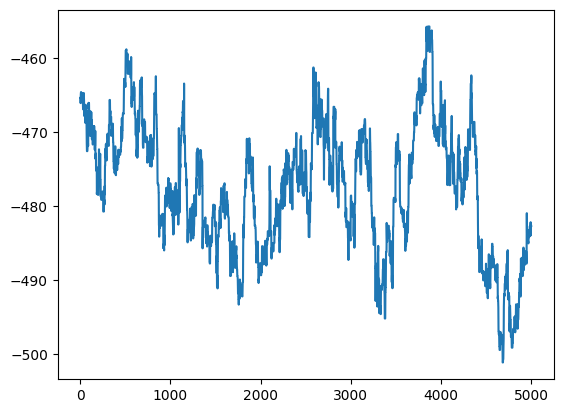

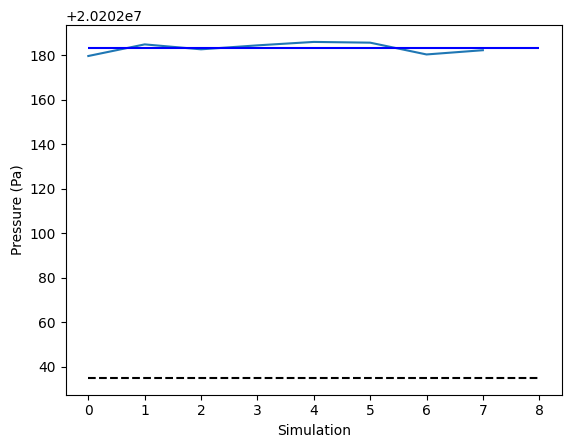

"\nplt.plot(durations)\nplt.xlabel('Simulation')\nplt.ylabel('Time (s)')\nplt.show()\n"

In [ ]:
# How big is too big, how small is too small
# Does the size of the box change the time: No, it does not seem so, at least not much
# Heat Capcity at larger and larger volumens, same particle
plot_amount = 5000
for sim in simulations:
  plt.plot(sim.energies[plot_amount:])
  Cvs.append(sim.calc_heat_capacity(equ = plot_amount, step = 1))
  print(f'Heat Capcity of simulation {sim}\n is {Cvs[-1]:.3e} kb')

plt.show()

plot_cut = 2
plt.plot(sim.pressures[plot_cut:])
plt.hlines([sim.ideal_pressure, np.mean(sim.pressures[plot_cut:])], 0, len(sim.pressures[plot_cut:]),
           linestyles=['dashed','-'], colors=['k','b'])
plt.xlabel('Simulation')
plt.ylabel('Pressure (Pa)')
plt.show()
'''
plt.plot(durations)
plt.xlabel('Simulation')
plt.ylabel('Time (s)')
plt.show()
'''

## Simulations near Freezing

In [ ]:
# Simulations near freezing
kb = 1.380649E-23 # J/K
simulations = []
durations = []
Cvs = []
Ls = [1.23]
steps = [50000]
pressure_steps = 100
for l,step in zip(Ls,steps):
  # T=2.275=273;  L = 12.3, n = 50, STP
  # 0.698 = 83.81=mp, rho = 1.3954g/mL;
  # T=0.727=87.3=bp
  sim = Simulation(move=0.05, N=50, L=l, T=0.6, seed = 2, epsilon=120, sigma=0.34, m=40, dim=3, verbose=True)
  durations.append(sim.run(step, move_gradient = None, pressure_steps=pressure_steps, keep_loc=False))
  print(f'Simulation {l} took {durations[-1]:.5g} seconds')
  simulations.append(sim)
  Cvs.append(sim.calc_heat_capacity(equ = 900, step = 10))
  print(f'Heat Capcity is {Cvs[-1]:.3e} kb')
  print('Pressures in Pascals: ')
  for p in sim.pressures:
      # Convert reduced pressure to Pascals
      pressure_pascals = p
      print(f'{pressure_pascals:.3e}', end=' : ')
  print('\n')

The number of particles is 50
The density of the system is 26.87 Atoms/nm^3 and 1.785 g/cm^3
Starting per particle energy 1.523e+15
Startin ideal pressure 2.671e+07
Ran 50000 in 82.048 seconds
Acceptance: 0.47002;    Rejection: 0.52998
Ending per particle energy -703
Simulation 1.23 took 82.048 seconds
Heat Capcity is 1.989e+05 kb
Pressures in Pascals: 
1.241e+15 : 6.724e+11 : 6.720e+11 : 2.733e+08 : 5.606e+07 : 3.856e+07 : 3.116e+07 : 2.941e+07 : 2.823e+07 : 2.691e+07 : 2.687e+07 : 2.676e+07 : 2.674e+07 : 2.666e+07 : 2.672e+07 : 2.672e+07 : 2.671e+07 : 2.671e+07 : 2.672e+07 : 2.674e+07 : 2.674e+07 : 2.673e+07 : 2.672e+07 : 2.672e+07 : 2.672e+07 : 2.671e+07 : 2.671e+07 : 2.671e+07 : 2.671e+07 : 2.671e+07 : 2.671e+07 : 2.671e+07 : 2.671e+07 : 2.671e+07 : 2.671e+07 : 2.671e+07 : 2.671e+07 : 2.671e+07 : 2.671e+07 : 2.671e+07 : 2.671e+07 : 2.671e+07 : 2.671e+07 : 2.671e+07 : 2.671e+07 : 2.671e+07 : 2.671e+07 : 2.671e+07 : 2.671e+07 : 2.671e+07 : 2.671e+07 : 2.671e+07 : 2.671e+07 : 2.671e+0

Heat Capcity of simulation Vol: 1.86, accept: 23501, reject 26499, steps: 50000
 is 1.341e+00 kb


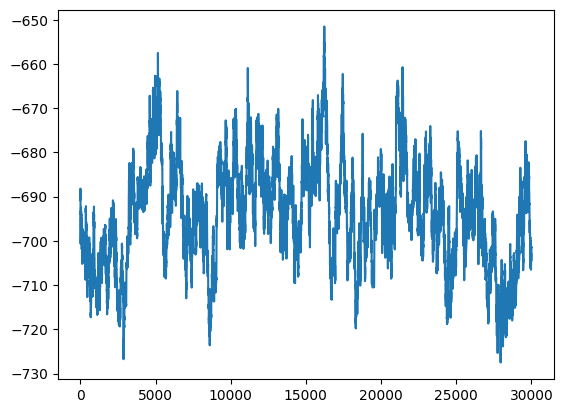

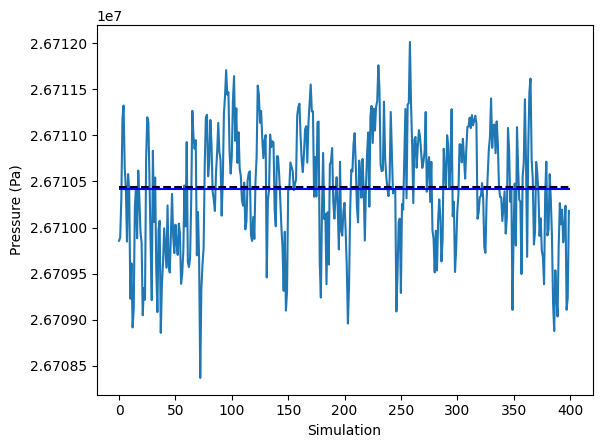

In [ ]:
# Plots near Freezing
plot_amount = 20000
for sim in simulations:
  plt.plot(sim.energies[plot_amount:])
  Cvs.append(sim.calc_heat_capacity(equ = plot_amount, step = 10))
  print(f'Heat Capcity of simulation {sim}\n is {Cvs[-1]:.3e} kb')

plt.show()

plot_cut = 100
plt.plot(sim.pressures[plot_cut:])
plt.hlines([sim.ideal_pressure, np.mean(sim.pressures[plot_cut:])], 0, len(sim.pressures[plot_cut:]),
           linestyles=['dashed','-'], colors=['k','b'])
plt.xlabel('Simulation')
plt.ylabel('Pressure (Pa)')
plt.show()

## Euqation of State

#### Constant Temperature
N will go from 10-300
V will be a what a gas phase would be at STP

In [ ]:
# How big is too big, how small is too small
# Does the size of the box change the time: No, it does not seem so, at least not much
# Heat Capcity at larger and larger volumens, same particle
kb = 1.380649E-23 # J/K
simulations = []
durations = []
Cvs = []
Ls = 12.3
steps = 10000
Ns = [10,30,50,70,90,110,130,150,170,190,210]
pressure_steps = 100
for N in Ns:
  # T=2.275=273;  L = 12.3, n = 50, STP
  # 0.698 = 83.81=mp, rho = 1.3954g/mL;
  # T=0.727=87.3=bp
  sim = Simulation(move=0.1, N=N, L=Ls, T=0.6, seed = 2, epsilon=120, sigma=0.34, m=40, dim=3, verbose=True)
  durations.append(sim.run(steps, move_gradient = None, pressure_steps=pressure_steps, keep_loc=False))
  print(f'Simulation {l} took {durations[-1]:.5g} seconds')
  simulations.append(sim)
  Cvs.append(sim.calc_heat_capacity(equ = 900, step = 10))
  print(f'Heat Capcity is {Cvs[-1]:.3e} kb')
  print(f'Pressures in Pascals: {sim.pressures[-1]:.4e}')
  print('\n')

The density of the system is 8.924 mol/m^3 and 0.0003569 g/cm^3
Starting per particle energy -0.04932
Startin ideal pressure 5342.1
Ran 10000 in 3.999 seconds
Acceptance: 0.9979;    Rejection: 0.0021
Ending per particle energy -8.278
Simulation 12.3 took 3.999 seconds
Heat Capcity is 6.946e+01 kb
Pressures in Pascals: 5.3421e+03


The density of the system is 26.77 mol/m^3 and 0.001071 g/cm^3
Starting per particle energy -0.1889
Startin ideal pressure 16026
Ran 10000 in 8.9697 seconds
Acceptance: 0.9911;    Rejection: 0.0089
Ending per particle energy -3.705
Simulation 12.3 took 8.9697 seconds
Heat Capcity is 2.315e+02 kb
Pressures in Pascals: 1.6026e+04


The density of the system is 44.62 mol/m^3 and 0.001785 g/cm^3
Starting per particle energy 1402
Startin ideal pressure 26710
Ran 10000 in 17.373 seconds
Acceptance: 0.9857;    Rejection: 0.0143
Ending per particle energy -2.075
Simulation 12.3 took 17.373 seconds
Heat Capcity is 2.421e+02 kb
Pressures in Pascals: 2.6710e+04


The de

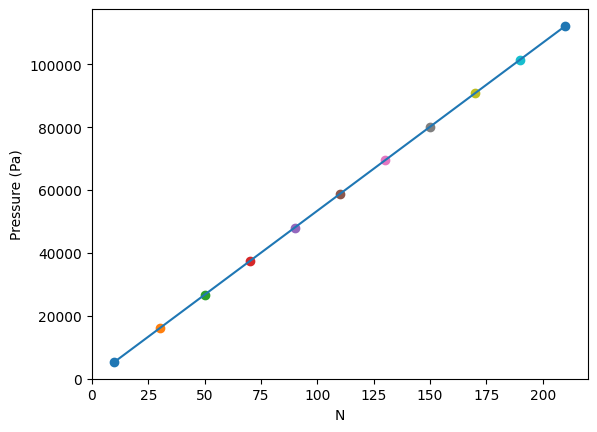

In [ ]:
# How big is too big, how small is too small
# Does the size of the box change the time: No, it does not seem so, at least not much
# Heat Capcity at larger and larger volumens, same particle
Ns = [10,30,50,70,90,110,130,150,170,190,210]

plot_amount = 5000
for i,sim in enumerate(simulations):
  plt.scatter(Ns[i], np.mean(sim.pressures[-30:]))
  Cvs.append(sim.calc_heat_capacity(equ = plot_amount, step = 10))
  #print(f'Heat Capcity of simulation {sim}\n is {Cvs[-1]:.3e} kb')

plt.plot(Ns, [sim.ideal_pressure for sim in simulations])
plt.xlabel('N')
plt.ylabel('Pressure (Pa)')
plt.show()

## Equation of State Varying Temperature
I will start at T=0.01 and go to T=5 or about 1K to 600K

In [ ]:
# How big is too big, how small is too small
# Does the size of the box change the time: No, it does not seem so, at least not much
# Heat Capcity at larger and larger volumens, same particle
kb = 1.380649E-23 # J/K
simulations = []
durations = []
Cvs = []
Ls = 12.3
steps = 10000
Ns = 50
Ts = [0.01,0.1,0.5,1,2,3,4,5]
pressure_steps = 100
for T in Ts:
  # T=2.275=273;  L = 12.3, n = 50, STP
  # 0.698 = 83.81=mp, rho = 1.3954g/mL;
  # T=0.727=87.3=bp
  sim = Simulation(move=0.1, N=Ns, L=Ls, T=T, seed = 2, epsilon=120, sigma=0.34, m=40, dim=3, verbose=True)
  durations.append(sim.run(steps, move_gradient = None, pressure_steps=pressure_steps, keep_loc=False))
  print(f'Simulation {l} took {durations[-1]:.5g} seconds')
  simulations.append(sim)
  Cvs.append(sim.calc_heat_capacity(equ = 900, step = 10))
  print(f'Heat Capcity is {Cvs[-1]:.3e} kb')
  print(f'Pressures in Pascals: {sim.pressures[-1]:.4e}')
  print('\n')

The number of particles is 50
The density of the system is 44.62 mol/m^3 and 0.001785 g/cm^3
Starting per particle energy 1402
Startin ideal pressure 445.17
Ran 10000 in 16.982 seconds
Acceptance: 0.7375;    Rejection: 0.2625
Ending per particle energy -23.83
Simulation 12.3 took 16.982 seconds
Heat Capcity is 5.563e+06 kb
Pressures in Pascals: 4.4517e+02


The number of particles is 50
The density of the system is 44.62 mol/m^3 and 0.001785 g/cm^3
Starting per particle energy 1402
Startin ideal pressure 4451.7
Ran 10000 in 16.045 seconds
Acceptance: 0.8196;    Rejection: 0.1804
Ending per particle energy -21.3
Simulation 12.3 took 16.045 seconds
Heat Capcity is 8.888e+04 kb
Pressures in Pascals: 4.4518e+03


The number of particles is 50
The density of the system is 44.62 mol/m^3 and 0.001785 g/cm^3
Starting per particle energy 1402
Startin ideal pressure 22259
Ran 10000 in 17.038 seconds
Acceptance: 0.985;    Rejection: 0.015
Ending per particle energy -2.182
Simulation 12.3 took 17.

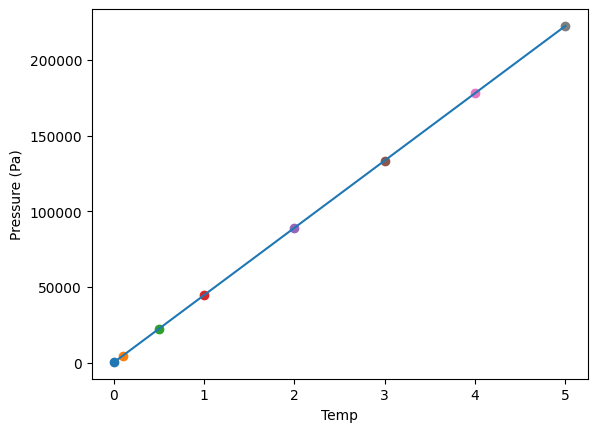

In [ ]:
Ts = [0.01,0.1,0.5,1,2,3,4,5]

plot_amount = 5000
for i,sim in enumerate(simulations):
  plt.scatter(Ts[i], np.mean(sim.pressures[-30:]))
  Cvs.append(sim.calc_heat_capacity(equ = plot_amount, step = 10))
  #print(f'Heat Capcity of simulation {sim}\n is {Cvs[-1]:.3e} kb')

plt.plot(Ts, [sim.ideal_pressure for sim in simulations])
plt.xlabel('Temp')
plt.ylabel('Pressure (Pa)')
plt.show()

### Equation of State Volume Varying

In [ ]:
kb = 1.380649E-23 # J/K
simulations = []
durations = []
Cvs = []
Ls = [1, 2, 3, 5, 8, 12, 17, 25, 50]
steps = 10000
Ns = 50
Ts = 0.6
pressure_steps = 100
for L in Ls:
  # T=2.275=273;  L = 12.3, n = 50, STP
  # 0.698 = 83.81=mp, rho = 1.3954g/mL;
  # T=0.727=87.3=bp
  sim = Simulation(move=0.1, N=Ns, L=L, T=Ts, seed = 2, epsilon=120, sigma=0.34, m=40, dim=3, verbose=True)
  durations.append(sim.run(steps, move_gradient = None, pressure_steps=pressure_steps, keep_loc=False))
  print(f'Simulation {l} took {durations[-1]:.5g} seconds')
  simulations.append(sim)
  Cvs.append(sim.calc_heat_capacity(equ = 900, step = 10))
  print(f'Heat Capcity is {Cvs[-1]:.3e} kb')
  print(f'Pressures in Pascals: {sim.pressures[-1]:.4e}')
  print('\n')

The number of particles is 50
The density of the system is 8.303e+04 mol/m^3 and 3.321 g/cm^3
Starting per particle energy 1.826e+16
Startin ideal pressure 4.9705e+07
Ran 10000 in 19.456 seconds
Acceptance: 0.0294;    Rejection: 0.9706
Ending per particle energy 1.191e+04
Simulation 12.3 took 19.456 seconds
Heat Capcity is 3.848e+09 kb
Pressures in Pascals: 4.9673e+07


The number of particles is 50
The density of the system is 1.038e+04 mol/m^3 and 0.4151 g/cm^3
Starting per particle energy 4.459e+12
Startin ideal pressure 6.2131e+06
Ran 10000 in 21.794 seconds
Acceptance: 0.369;    Rejection: 0.631
Ending per particle energy -284.5
Simulation 12.3 took 21.794 seconds
Heat Capcity is 4.126e+04 kb
Pressures in Pascals: 6.2131e+06


The number of particles is 50
The density of the system is 3075 mol/m^3 and 0.123 g/cm^3
Starting per particle energy 3.437e+10
Startin ideal pressure 1.8409e+06
Ran 10000 in 21.885 seconds
Acceptance: 0.6068;    Rejection: 0.3932
Ending per particle energy 

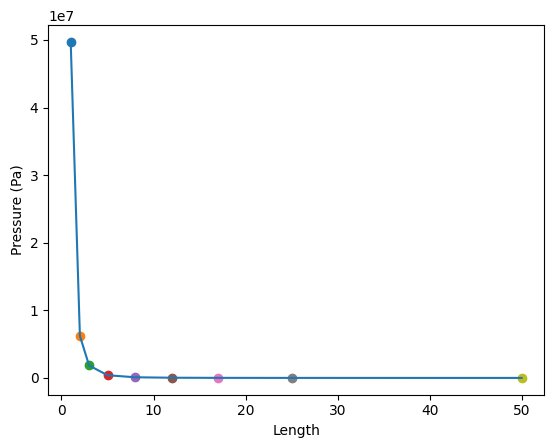

In [ ]:
Ls = [1, 2, 3, 5, 8, 12, 17, 25, 50]

plot_amount = 5000
for i,sim in enumerate(simulations):
  plt.scatter(Ls[i], np.mean(sim.pressures[-30:]))
  Cvs.append(sim.calc_heat_capacity(equ = plot_amount, step = 10))
  #print(f'Heat Capcity of simulation {sim}\n is {Cvs[-1]:.3e} kb')

plt.plot(Ls, [sim.ideal_pressure for sim in simulations])
plt.xlabel('Box Length')
plt.ylabel('Pressure (Pa)')
plt.show()

[(-1, -1), (-1, 0), (-1, 1), (0, -1), (0, 0), (0, 1), (1, -1), (1, 0), (1, 1)]
Help on class product in module itertools:

class product(builtins.object)
 |  product(*iterables, repeat=1) --> product object
 |  
 |  Cartesian product of input iterables.  Equivalent to nested for-loops.
 |  
 |  For example, product(A, B) returns the same as:  ((x,y) for x in A for y in B).
 |  The leftmost iterators are in the outermost for-loop, so the output tuples
 |  cycle in a manner similar to an odometer (with the rightmost element changing
 |  on every iteration).
 |  
 |  To compute the product of an iterable with itself, specify the number
 |  of repetitions with the optional repeat keyword argument. For example,
 |  product(A, repeat=4) means the same as product(A, A, A, A).
 |  
 |  product('ab', range(3)) --> ('a',0) ('a',1) ('a',2) ('b',0) ('b',1) ('b',2)
 |  product((0,1), (0,1), (0,1)) --> (0,0,0) (0,0,1) (0,1,0) (0,1,1) (1,0,0) ...
 |  
 |  Methods defined here:
 |  
 |  __getattribute